In [1]:
#!pip install netcdf4
#!pip install rioxarray
#!pip install regionmask

import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
import os
import regionmask
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from ci_adapt_classes import *
from shapely import Point
import ast


from datetime import datetime

In [64]:
!config.py

In [2]:
config_file = r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

# Set paths and data sources
p = Path('..')
miraca_data = Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'event_data_inspection'/ 'overlapping_floods_shapefiles'

# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)



In [3]:
# Functions definition

#filter the discharge dataset to the desired time range and bounding box
def find_max_discharge_in_basin(basin_path, discharge_nc):
    # Load basin and find bounding box
    basin = gpd.read_file(basin_path)
    lon1,lat1,lon2,lat2 = get_bbox(basin_path)

    # Load discharge data and filter to the bounding box
    thresholds_mu = xr.open_dataset(discharge_nc).sel(lon = slice(lon1,lon2), lat = slice(lat2,lat1))

    # Mask the discharge data to the basin
    basin_mask = regionmask.mask_geopandas(basin, thresholds_mu)
    inverted_basin_mask = basin_mask.where(basin_mask.isnull(), -1)
    inverted_basin_mask = inverted_basin_mask.where(inverted_basin_mask.notnull())
    thresholds_mu_masked = thresholds_mu.where(inverted_basin_mask.notnull())

    # Find the lat lon with the highest discharge value within the basin
    max_dis_mu = thresholds_mu_masked['mu'].max()
    max_dis_mu_lon = thresholds_mu_masked['lon'].where(thresholds_mu_masked['mu'] == max_dis_mu).values
    max_dis_mu_lat = thresholds_mu_masked['lat'].where(thresholds_mu_masked['mu'] == max_dis_mu).values
    max_dis_mu_lon = max_dis_mu_lon[~np.isnan(max_dis_mu_lon)]
    max_dis_mu_lat = max_dis_mu_lat[~np.isnan(max_dis_mu_lat)]

    try:
        return max_dis_mu.values, (max_dis_mu_lon[0], max_dis_mu_lat[0])
    except Exception as e:
        print(f'Error in find_max_discharge_in_basin: {basin_path}')
        print(e)
        return None, (None, None)

def get_bbox(path):
    gdf = gpd.read_file(path)
    gdf = gdf.to_crs('epsg:4326')
    return gdf.total_bounds

# Find the peak discharge at a location over several timesteps
def get_peak_discharge(discharge_data,lon, lat, t0, t1):
    if lat == None or lon == None or t0 == None or t1 == None:
        return None, None
    # Find time range
    year_start = t0.year
    year_end = t1.year
    if year_start != year_end:
        years = [str(year) for year in range(year_start, year_end+1)]
    else:
        years = [str(year_start)]

    # Open the data for the year and location specified
    max_discharges = {}
    for year in years:
        try:
            discharge_nc = f'dis.HERA{year}.nc'
            discharge = xr.open_dataset(discharge_data / discharge_nc).sel(time=slice(t0, t1),lon = slice(lon - 0.05, lon + 0.05), lat = slice(lat + 0.05, lat - 0.05))
            discharge = discharge.sel(lon=lon, lat=lat, method='nearest')
            
            # Find the maximum value of the timeseries and the time of occurrence
            max_discharge = discharge['dis'].max()
            for t in discharge.time:
                if max_discharge.values is not None:
                    max_discharges[t.values] = max_discharge.values
                else:
                    break
            
            # If there is no discharge in the area (catchment area too small), discharge is 0
            if len(max_discharges) == 0:
                peak_discharge = 0
                peak_time = 0
            else:
                peak_discharge = max(max_discharges.values())
                peak_time = [k for k, v in max_discharges.items() if v == peak_discharge][0]
        except Exception as e:
            print(f'Error in get_peak_discharge for year {year}: {e}')
            return None, None

    return peak_discharge, peak_time

# For a given coordenate, find the threshold discharge values for all the return periods
def find_threshold_discharge_at_point(thresholds_ncs, lon, lat):
    rp_thresholds = [rp for rp in os.listdir(thresholds_ncs) if rp.endswith('.nc')]
    thresholds_dict = {}
    for thresholds_nc in rp_thresholds:
        try:
            rp=float(thresholds_nc.split('_')[-1].split('.n')[0])
        except ValueError:
            continue
        
        threshold = xr.open_dataset(thresholds_ncs/thresholds_nc).sel(lon = lon, lat = lat, method = 'nearest')
        thresholds_dict[rp] = threshold['rl_'+str(rp)].values

    return thresholds_dict

# Interpolate the return period for a given discharge value 
def interp_discharge_rp(peak_discharge, rp_thresholds):
    
    rps=[float(x) for x in rp_thresholds.keys()]
    discharge_thresholds=[float(rp_thresholds[rp]) for rp in rps]
    try:
        if float(peak_discharge)<float(discharge_thresholds[0]):
            return 0
        rp=np.interp(float(peak_discharge),discharge_thresholds,rps)
        return rp
    except TypeError:
        pass


In [4]:
# Find the coordinates of the highest discharge value in each basin

thresholds_ncs = data_path / 'Floods/flood_thresholds_efas'
discharge_mu_nc = thresholds_ncs / 'flood_threshold_efas_v5.1_mu.nc'
basins_path = data_path / 'Floods/basins'
basins = [f for f in os.listdir(basins_path) if f.endswith('.shp')]
discharge_sample_points = {}

for basin in basins:
    basin_id = basin.split('_')[-1].split('.')[0]
    basin_path = basins_path / basin
    max_dis_mu, (max_dis_mu_lon, max_dis_mu_lat) = find_max_discharge_in_basin(basin_path, discharge_mu_nc)
    discharge_sample_points[basin_id] = (max_dis_mu_lon, max_dis_mu_lat)


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\regionmask\core\_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


Error in find_max_discharge_in_basin: C:\Data\Floods\basins\hybas_eu_2080418720.shp
index 0 is out of bounds for axis 0 with size 0


In [5]:
basin_thresholds_dict={}
for basin_id, (lon, lat) in discharge_sample_points.items():   
    basin_thresholds_dict[basin_id] = dict(sorted(find_threshold_discharge_at_point(thresholds_ncs, lon, lat).items()))

In [6]:
basin_thresholds_dict['2080410170']

{1.5: array(128.58272, dtype=float32),
 2.0: array(144.73708, dtype=float32),
 5.0: array(184.49251, dtype=float32),
 10.0: array(210.81407, dtype=float32),
 20.0: array(236.06235, dtype=float32),
 50.0: array(268.74365, dtype=float32),
 100.0: array(293.23367, dtype=float32),
 200.0: array(317.63434, dtype=float32),
 500.0: array(349.82642, dtype=float32)}

In [7]:
pd.DataFrame.from_dict(discharge_sample_points, orient='index', columns=['lon', 'lat']).head(1)
#pd.DataFrame.from_dict(discharge_sample_points, orient='index', columns=['lon', 'lat']).to_csv(data_path / 'interim/discharge_sample_points.csv')

,lon,lat
2080410170,7.858333,50.808334


In [9]:
floods_df = pd.read_csv(r'C:\Data\Floods\Paprotny Flood Events Data\HANZE_potential_flood_catalogue_all.csv')
floods_df = floods_df[floods_df['Country code'] == 'DE']
floods_df = floods_df[floods_df['Type'] == 'River']
floods_df.sort_values(by = 'Return period', inplace = True, ascending = True)

events = os.listdir(interim_data_path)
events = [e for e in events if e.endswith('.shp')]

event_basin_overlaps = pd.read_csv(r'C:\Data\interim\event_data_inspection\overlapping_floods_shapefiles\hybas_id_event_overlaps.csv', index_col = 0)


In [12]:
discharge_data = miraca_data/'HERA_data/river_discharge'
target = data_path / 'interim/peak_discharges_paprotny_events_basins.csv'
peak_discharges = {}

for event in tqdm(events, desc = 'Processing events', total = len(events)):
    event_path = interim_data_path/event
    event_name = os.path.basename(event_path).split('.')[0]
    event_id = str(event_name.split('_')[1])

    if len(floods_df[floods_df['ID'] == int(event_id)]) == 0:
        continue

    event_start_date = datetime.strptime(floods_df[floods_df['ID'] == int(event_id)]['Start date'].values[0], '%d/%m/%Y')
    event_end_date = datetime.strptime(floods_df[floods_df['ID'] == int(event_id)]['End date'].values[0], '%d/%m/%Y')
    event_duration = event_end_date-event_start_date

    try:
        event_matches = event_basin_overlaps.loc[event].dropna().to_list()
    except KeyError:
        continue

    for basin_id in event_matches:
        lon, lat = discharge_sample_points[str(int(basin_id))]

        peak_discharges[event, str(int(basin_id))] = get_peak_discharge(discharge_data,
                                t0 = event_start_date,
                                t1 = event_end_date,
                                lon = lon,
                                lat = lat)

peak_discharges_df = pd.DataFrame.from_dict(peak_discharges, orient='index', columns=['peak_discharge', 'peak_time'])        
peak_discharges_df.to_csv(target, mode='a', header=True)  


Processing events:   1%|▏         | 7/532 [01:31<1:54:28, 13.08s/it]


KeyboardInterrupt: 

In [13]:
peak_discharges_df = pd.DataFrame.from_dict(peak_discharges, orient='index', columns=['peak_discharge', 'peak_time'])        
peak_discharges_df

,peak_discharge,peak_time
"(Event_28000_DE_1950_River.shp, 2080421680)",113.8892822265625,1950-02-01
"(Event_28000_DE_1950_River.shp, 2080410170)",65.941650390625,1950-02-01
"(Event_28000_DE_1950_River.shp, 2080429430)",2272.067138671875,1950-02-01
"(Event_28000_DE_1950_River.shp, 2080429540)",3.8963623046875,1950-02-01
"(Event_28000_DE_1950_River.shp, 2080429670)",2283.00830078125,1950-02-01
...,...,...
"(Event_28009_DE_1951_River.shp, 2080421680)",145.22064208984375,1951-03-14
"(Event_28009_DE_1951_River.shp, 2080410170)",71.5091552734375,1951-03-14
"(Event_28009_DE_1951_River.shp, 2080410430)",19.47393798828125,1951-03-14
"(Event_28009_DE_1951_River.shp, 2080429430)",1996.6309814453125,1951-03-14


In [14]:

events_rp={}
for (event, basin_id), (peak_dis, peak_time) in peak_discharges.items():
    events_rp[event, basin_id]=interp_discharge_rp(peak_dis, basin_thresholds_dict[basin_id])

events_rp

#TODO: check if discharge sampling point aligns with event grid

{('Event_28000_DE_1950_River.shp', '2080421680'): 0,
 ('Event_28000_DE_1950_River.shp', '2080410170'): 0,
 ('Event_28000_DE_1950_River.shp', '2080429430'): 0,
 ('Event_28000_DE_1950_River.shp', '2080429540'): 0,
 ('Event_28000_DE_1950_River.shp', '2080429670'): 0,
 ('Event_28000_DE_1950_River.shp', '2080429770'): 0,
 ('Event_28000_DE_1950_River.shp', '2080431110'): 0,
 ('Event_28000_DE_1950_River.shp', '2080436870'): 0,
 ('Event_28000_DE_1950_River.shp', '2080438230'): 0,
 ('Event_28000_DE_1950_River.shp', '2080438240'): 0,
 ('Event_28000_DE_1950_River.shp', '2080439400'): 0,
 ('Event_28000_DE_1950_River.shp', '2080439410'): 0,
 ('Event_28000_DE_1950_River.shp', '2080441280'): 0,
 ('Event_28000_DE_1950_River.shp', '2080446220'): 0,
 ('Event_28000_DE_1950_River.shp', '2080446320'): 0,
 ('Event_28000_DE_1950_River.shp', '2080447840'): 0,
 ('Event_28007_DE_1950_River.shp', '2080411370'): 0,
 ('Event_28007_DE_1950_River.shp', '2080416210'): 0,
 ('Event_28007_DE_1950_River.shp', '2080416200

In [19]:
sorted([x for x in events_rp.values() if x is not None], reverse=True)

[4.733342183318319,
 4.695066066953858,
 4.694769684026481,
 4.693596213972083,
 4.693284423990557,
 4.693023803668811,
 4.2372304217940115,
 3.898940940537221,
 3.89286138123506,
 3.877475867489023,
 3.8718980194759594,
 3.8613708549193353,
 3.860870780983761,
 3.853361510119723,
 3.8524545422945176,
 3.7684917963525884,
 3.761910354096483,
 3.6649845416437765,
 3.6464076061852237,
 3.64502680623981,
 3.5760861053878266,
 3.544895089673341,
 3.5275055533504345,
 3.5269304421601904,
 3.5014192275810854,
 3.482119395391929,
 3.4585804335523997,
 3.457755929281305,
 3.446348938100246,
 3.4399538544885218,
 3.4310180871435803,
 3.415656459372293,
 3.4035486945164015,
 3.3934709577908757,
 3.3926936485565333,
 3.121166047505639,
 3.051292405591096,
 3.0456861352414974,
 3.0114485972522864,
 2.9993623587310694,
 2.9979408003610653,
 2.858428854408393,
 2.652586706201921,
 2.6449526947497612,
 2.620174876342697,
 2.5166503588991103,
 2.50308919843656,
 2.4801592984298937,
 2.4752260994682946

In [38]:
peak_discharges_df = pd.DataFrame.from_dict(peak_discharges, orient = 'index')
peak_discharges_df.to_csv(r'C:\Data\interim\event_data_inspection\peak_discharges_3.csv')




In [58]:
event_of_interest=[(event, basin_id) for (event, basin_id), ret_per in events_rp.items() if ret_per==36.07875797176108]
floods_df[floods_df['ID'] == int(event_of_interest[0][0].split('_')[1])]


,ID,Country code,Year,Country name,Start date,End date,Type,Source,Regions affected (NUTS v2010),Regions affected (NUTS v2021),...,"Economic loss, YE","Economic loss, 1950","Economic loss, 2020",Loss threshold,Mean water depth,Return period,Hydro data,RP2 exceedance,Category,HANZE ID
4056,28742,DE,2011,Germany,06/01/2011,27/01/2011,River,Agger;Ahr;Aisch;Aller;Altmuhl;Blies;Dill;Donau...,DE111;DE112;DE113;DE114;DE115;DE116;DE117;DE11...,DE111;DE112;DE113;DE114;DE115;DE116;DE117;DE11...,...,397279566,50746234,478143287,783146,1919,29.05,1,1,A,350


In [61]:
rps_for_event_of_interest=[(ret_per, event, basin_id) for (event, basin_id), ret_per in events_rp.items() if event==event_of_interest[0][0] and ret_per is not None]
sorted(rps_for_event_of_interest, reverse=True)

[(36.07875797176108, 'Event_28742_DE_2011_River.shp', '2080451930'),
 (32.88488192847303, 'Event_28742_DE_2011_River.shp', '2080435320'),
 (31.8495909165076, 'Event_28742_DE_2011_River.shp', '2080421680'),
 (30.713211749465625, 'Event_28742_DE_2011_River.shp', '2080438410'),
 (30.450827332339948, 'Event_28742_DE_2011_River.shp', '2080448120'),
 (30.153699347593204, 'Event_28742_DE_2011_River.shp', '2080447970'),
 (26.928850696014877, 'Event_28742_DE_2011_River.shp', '2080438400'),
 (23.207452459143184, 'Event_28742_DE_2011_River.shp', '2080432510'),
 (22.884899243147323, 'Event_28742_DE_2011_River.shp', '2080435040'),
 (22.352382302264704, 'Event_28742_DE_2011_River.shp', '2080432400'),
 (22.192828085044525, 'Event_28742_DE_2011_River.shp', '2080430320'),
 (21.788941357920383, 'Event_28742_DE_2011_River.shp', '2080434280'),
 (19.04685182671151, 'Event_28742_DE_2011_River.shp', '2080418600'),
 (18.913272111533892, 'Event_28742_DE_2011_River.shp', '2080434490'),
 (14.75362577757528, 'Eve

lats: 50.341099375783635 50.45035332275069 lons: 7.470833333333361 7.750000000000027


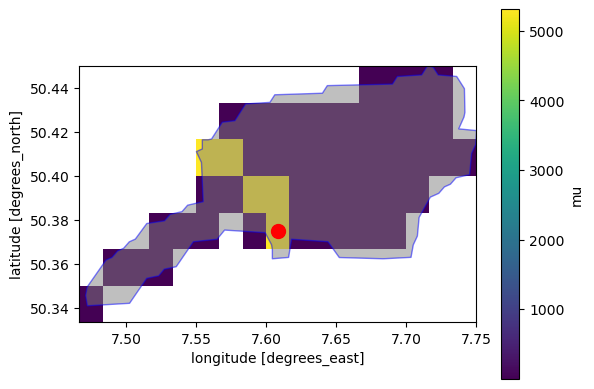

In [15]:
basins = [f for f in os.listdir(basins_path) if f.endswith('.shp')]

basin_filt = [bas for bas in basins if '2080419180' in bas][0]
basin_id = basin_filt.split('_')[-1].split('.')[0]
basin_path = basins_path / basin_filt
max_dis_mu, (max_dis_mu_lon, max_dis_mu_lat) = find_max_discharge_in_basin(basin_path, discharge_mu_nc)
discharge_sample_points[basin_id] = (max_dis_mu_lon, max_dis_mu_lat)


discharge_mu = xr.open_dataset(discharge_mu_nc)
bbox_basin = get_bbox(basin_path)
lon1,lat1,lon2,lat2 = bbox_basin
discharge_mu = discharge_mu.sel(lon = slice(lon1,lon2), lat = slice(lat2,lat1))

#now filter the values that are strictly within the basin
# basin_mask = regionmask.mask_geopandas(basin, discharge_mu['rl_1.5'])
basin = gpd.read_file(basin_path)
basin_mask = regionmask.mask_geopandas(basin, discharge_mu)

# Replace NaNs with -1 and valid region numbers with NaNs
inverted_basin_mask = basin_mask.where(basin_mask.isnull(), -1)
inverted_basin_mask = inverted_basin_mask.where(inverted_basin_mask.notnull())

# Apply the inverted mask
# discharge_mu_masked = discharge_mu['rl_1.5'].where(inverted_basin_mask.notnull())
discharge_mu_masked = discharge_mu.where(inverted_basin_mask.notnull())

# discharge_mu
fig, ax = plt.subplots()
print(f'lats: {lat1} {lat2} lons: {lon1} {lon2}')
# dsplot = discharge_mu_masked
dsplot = discharge_mu_masked

dsplot['mu'].plot(ax = ax, cmap = 'viridis')


# # overlay the catchment boundary
basin.plot(ax = ax, facecolor = 'none', edgecolor = 'blue', color = 'grey', alpha = 0.5)

# find the lat lon with the highest rl_1.5 value within the basin
max_mu_dis = dsplot['mu'].max()
max_mu_dis_lon = dsplot['lon'].where(dsplot['mu'] == max_mu_dis).values
max_mu_dis_lat = dsplot['lat'].where(dsplot['mu'] == max_mu_dis).values

#remove all the nans   
max_mu_dis_lon = max_mu_dis_lon[~np.isnan(max_mu_dis_lon)]
max_mu_dis_lat = max_mu_dis_lat[~np.isnan(max_mu_dis_lat)]

# plot the max mean discharge point
ax.plot(max_mu_dis_lon, max_mu_dis_lat, 'ro', markersize = 10)


In [31]:
# Create visualisation for the basin and the discharge points
from lonboard import viz, Map, PolygonLayer, ScatterplotLayer, PointCloudLayer

# Generate the discharge points layer
discharge_points = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for bas_id, (lon, lat) in discharge_sample_points.items() 
                  if (lon is not None and lat is not None) and bas_id==basin_id]},
                  crs='EPSG:4326')

if not discharge_points.empty:
    layer_discharge_pts = ScatterplotLayer.from_geopandas(discharge_points,
    get_fill_color=miraca_colors['yellow_alert'],
    get_radius=200,
    auto_highlight=True,
    opacity=0.8)
else:
    layer_discharge_pts = None
    
# Set path for basin to add to visualization
basin_path = rf'C:\Data\Floods\basins\hybas_eu_{int(basin_id)}.shp'

# Generate the basin layer
basin = gpd.read_file(basin_path)
layer_basin = PolygonLayer.from_geopandas(basin,
    get_fill_color=miraca_colors['grey_300'],
    get_line_color=miraca_colors['primary blue'], auto_highlight=True,
    opacity=0.2)

# Flood return period: H for frequent(RP10-20), M for 100 year return period (RP100) and L for extreme (RP2000)
return_period_str='M'
# Generate flood layers and protection layers for visualization
flood_plot_path=rf'Floods\Germany\basin_intersections\DERP_RW_{return_period_str}_4326_hybas_intersections\flood_DERP_RW_{return_period_str}_4326_{basin_id}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.7, 
                                                            stroked=False))

layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
if layers_flood is not None:
    layers.extend(layers_flood)
if layer_discharge_pts is not None:
    layers.append(layer_discharge_pts)
m = Map(layers)

m


Map(layers=[PolygonLayer(auto_highlight=True, get_fill_color=(188, 191, 204, 255), get_line_color=(64, 105, 24…

In [29]:
# [Point(lon, lat) for bas_id, (lon, lat) in discharge_sample_points.items() 
#                   if (lon is not None and lat is not None) and (int(bas_id) in event_matches)
#                   and int(bas_id)==int(basin_id)]
# discharge_sample_points
# basin_id
# discharge_sample_points['2080419180']
event_matches

[2080441280.0, 2080447840.0]

<Axes: >

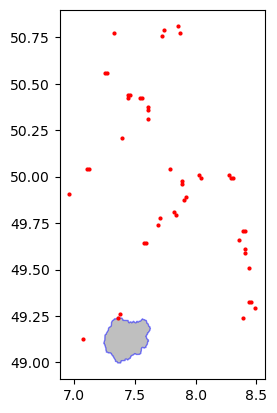

In [115]:
#create path for basin to add to visualization
# basin_path = rf'C:\Data\Floods\basins\hybas_eu_{basin_id}.shp'

# # check if the target exists or return path
# if os.path.exists(basin_path):
#     basin = gpd.read_file(basin_path)
# fig, ax = plt.subplots()

# # # Plot the discharge sampling points
# for basin_id in event_matches:
#     lon, lat = discharge_sample_points[str(int(basin_id))]
#     if lon is None or lat is None:
#         continue
    
#     ax.plot(lon, lat, 'ro', markersize = 2, label = f'Basin {basin_id}')



# basin.plot(ax = ax, facecolor = 'none', edgecolor = 'blue', color = 'grey', alpha = 0.5)


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\contextily\tile.py:623: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


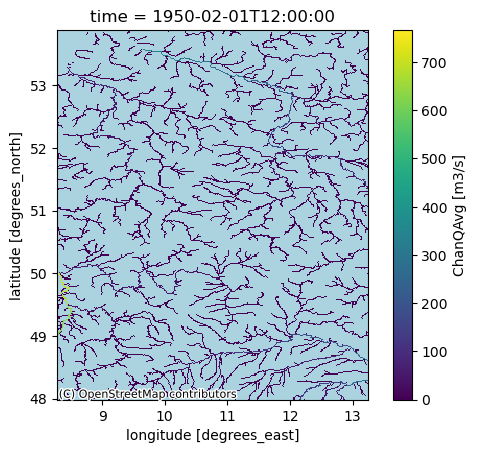

In [ ]:
# import contextily as ctx
# fig, ax = plt.subplots()

# dsplot = discharge.isel(time = 2)
# dsplot.dis.plot(ax = ax)
# # overlay the catchment boundary
# basin.plot(ax = ax, facecolor = 'none', edgecolor = 'blue', color = 'cyan', alpha = 0.5)

# ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)




AttributeError: 'QuadMesh' object has no attribute 'axis'

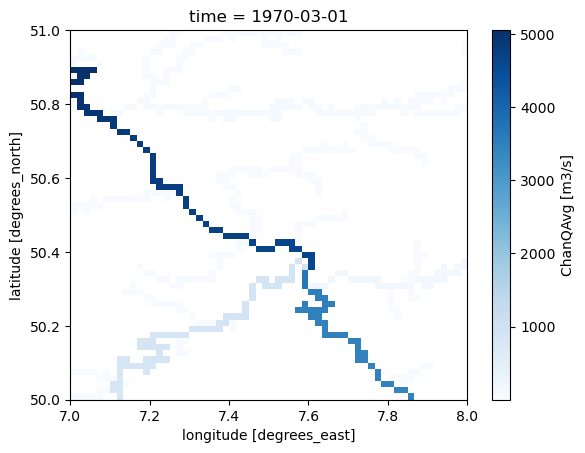

In [ ]:
# import contextily as ctx
# from time import sleep

# for t in ds.time:
#     dsplot = ds.sel(time = t)
#     ax = dsplot.dis.plot(cmap = plt.cm.Blues)
#     #ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zoom_adjust = 1)
#     sleep(1)
#     break
